In [1]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [2]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [3]:
test_size = 9216
train_size = 24649
test_path = 'samples/test_data_f3_plain_' + str(test_size) + '/'
train_path = 'samples/train_data_f3_hole_' + str(train_size) + '/'

# Training and Testing samples
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)
x_train, y_train = deserialize("REG_x_train", train_path), deserialize("REG_y_train", train_path)

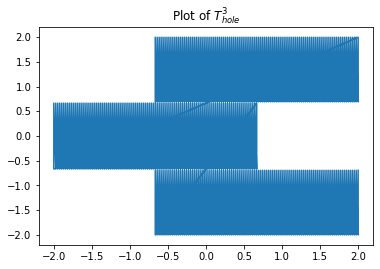

In [4]:
plt.plot(x_train[:,0], x_train[:, 1])
plt.title("Plot of $T_{hole}^3$")
plt.savefig("y_train_f3.png", dpi=200)

In [5]:
archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]

full_err = np.array([])
full_out = np.array([])
full_dist = np.array([])
full_xtest = np.array([])
X = x_test.detach().numpy()

for width, depth in archs:
    for sampling_method in ['REG', 'UNI', 'SOB']:
        for state in ['hole', 'plain']:
            path = "serialized_" + state + "/serialized_data_" + sampling_method
            for test_num in range(1, 9):
                # Deserialize the data using pickle
                folder_name = path + f"_{width}_{depth}_{test_num}"
                list_names = ["mean_dist", "num_out", "output_test", "gensample_err"]
                list_data = []
                for name in list_names:
                    list_data.append(deserialize(name, folder_name))
                mean_dist = np.array(list_data[0])
                num_out = np.array(list_data[1])
                output_test = list_data[2].detach().numpy()
                gen_err = np.array(list_data[3])
                
                if state == 'plain':
                    # create a boolean mask based on your conditions
                    mask = np.logical_or.reduce([ (-2 <= X[:, 0]) & (X[:, 0] <= 2) & (-2 <= X[:, 1]) & (X[:, 1] <= -1),
                                                (-2 <= X[:, 0]) & (X[:, 0] <= -1) & (-1 <= X[:, 1]) & (X[:, 1] <= 2),
                                                (-2 <= X[:, 0]) & (X[:, 0] <= 2) & (1 <= X[:, 1]) & (X[:, 1] <= 2),
                                                (1 <= X[:, 0]) & (X[:, 0] <= 2) & (-1 <= X[:, 1]) & (X[:, 1] <= 1)
                                                ])
                else:
                    mask = np.logical_or((-2 <= X[:, 0]) & (X[:, 0] <= -0.667) & (0.667 <= X[:, 1]) & (X[:, 1] <= 2),
                                        (0.667 <= X[:, 0]) & (X[:, 0] <= 2) & (-0.667 <= X[:, 1]) & (X[:, 1] <= 0.667),
                                        (-2 <= X[:, 0]) & (X[:, 0] <= -0.667) & (-2 <= X[:, 1]) & (X[:, 1] <= -0.667))

                full_err = np.concatenate((full_err, gen_err[mask]))
                full_out = np.concatenate((full_out, num_out[mask]))
                full_dist = np.concatenate((full_dist, mean_dist[mask]))

Slope (a_out): 0.06739958124852902
Intercept (b_out): 0.8963701091662615
Slope (a): 0.5582741247179009
Intercept (b): 0.49881929614381


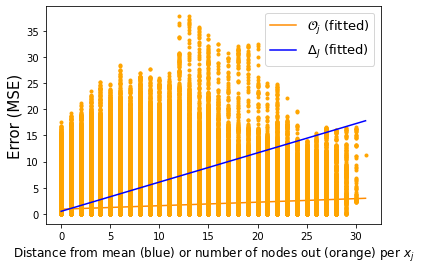

In [6]:
# calculate polynomial
z_out = np.polyfit(full_out, full_err, 1)
a_out = z_out[0] # slope
b_out = z_out[1] # intercept

# print coefficients
print("Slope (a_out):", a_out)
print("Intercept (b_out):", b_out)

# calculate new x's and y's
x_out = np.linspace(min(full_out), max(full_out), 100)
y_out = a_out*x_out + b_out

plt.plot(x_out, y_out, label=r"$\mathcal{O}_j$ (fitted)", color='darkorange')
plt.plot(full_out, full_err, '.', color='orange')

z_dist = np.polyfit(full_dist, full_err, 1)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_out), max(full_out), 100)
y_dist = a_dist*x_dist + b_dist

plt.plot(x_dist, y_dist, label=r"$\Delta_J$ (fitted)", color='blue')

plt.xlabel(r"Distance from mean (blue) or number of nodes out (orange) per $x_j$", fontsize=12)
plt.ylabel("Error (MSE)", fontsize=15)
plt.legend(fontsize=13)
plt.savefig("images/F3NetsUnseenInput.png", dpi=100)